# Контест 1
Гиголаев Антон М80-209Б-22

# Установим и импортируем библиотеки

In [24]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import TargetEncoder 
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

# Загрузим обучающую и тестовую выборки

In [26]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### CHECK

In [27]:
train.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


### CHECK

In [28]:
test.head()

,ID,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,0,1979-01-03,49,207095,850,14458,60,Single,0,Rent,...,6,Employed,High School,23,10626,0.104458,0.125350,325.532336,0.040650,1
1,1,2006-04-10,28,64653,674,65491,48,Single,2,Own,...,3,Employed,High School,3,299024,0.233491,0.260561,2210.247757,0.454410,0
2,2,2013-11-28,41,300000,768,16811,60,Single,1,Own,...,3,Employed,High School,19,6979,0.147811,0.154571,403.977431,0.034919,1
3,3,1995-08-24,50,300000,850,48737,36,Divorced,0,Mortgage,...,3,Self-Employed,Bachelor,26,8438,0.118737,0.099712,1571.946906,0.085558,1
4,4,1980-06-15,35,300000,672,51916,60,Single,6,Mortgage,...,7,Employed,Associate,12,436216,0.230916,0.237727,1486.675235,0.063707,1


### Выделим фичи

In [29]:
features = train.select_dtypes(object).columns
features

Index(['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus',
       'LoanPurpose', 'EmploymentStatus', 'EducationLevel'],
      dtype='object')

## Препроцессинг

In [30]:
train = train.dropna(subset=features, axis=0)
test = test.dropna(subset=features, axis=0)

### Создадим DATAFRAME для таргетов

In [31]:
target = train['RiskScore']

### Зададим функцию перевода классов в числовые значения весов в зависимости от таргета.
Для этого создадим энкодер и обучим его на основе train датасета
Классы для перевода - ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']

In [32]:
def features_to_weight_by_mean_target(train_frame, test_frame, features: list[str]):
  encoder = TargetEncoder()
  for feature in features:
    encoder = encoder.fit(train_frame[feature].values.reshape(-1, 1), target.values)
    train_frame[feature] = encoder.transform(train_frame[feature].values.reshape(-1, 1))
    test_frame[feature] = encoder.transform(test_frame[feature].values.reshape(-1, 1))

In [33]:
def label_encode(df, features: list[str], df_test):
  le = LabelEncoder()
  for feature in features:
    le = le.fit(df[feature].values)
    df[feature] = le.transform(df[feature])
    df_test[feature] = le.transform(df_test[feature])

label_encoded_features =  ['EducationLevel', 'EmploymentStatus']
label_encode(train, label_encoded_features, test)

### Используем функцию и выведем модифицированный датасет

In [34]:
mean_target_encoded_features = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
features_to_weight_by_mean_target(train, test, mean_target_encoded_features)
train

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,-40162.315572,1.0,-32987.689127,1095.0,...,0,0,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,-56180.985813,1.0,-32788.988379,211.0,...,0,3,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,-28454.639853,0.0,-32788.988379,546.0,...,0,1,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,-28454.639853,0.0,20350.571111,153.0,...,0,3,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,-26191.817952,2.0,-32987.689127,562.0,...,0,1,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11010,1984-09-26,47.0,88686.0,648.0,5472.0,12.0,-40162.315572,2.0,-32987.689127,98.0,...,0,1,23.0,121698.0,0.156472,0.164928,497.756143,0.080611,1.0,41.553066
11011,1980-01-15,39.0,300000.0,850.0,7721.0,72.0,-40162.315572,5.0,-49523.589815,276.0,...,0,0,16.0,18607.0,0.107721,0.108596,146.407421,0.016896,1.0,28.051757
11012,2010-07-10,57.0,300000.0,850.0,14756.0,48.0,-28454.639853,2.0,-49523.589815,620.0,...,0,0,38.0,167544.0,0.094756,0.106387,378.792448,0.039952,1.0,32.440586
11013,2003-10-22,28.0,15000.0,300.0,51361.0,96.0,-26191.817952,1.0,-49523.589815,696.0,...,0,1,5.0,116879.0,0.446361,0.401087,1793.042130,1.991234,0.0,67.673170


In [35]:
train = train[train['RiskScore'] > train['RiskScore'].quantile(q=0.01)]
train = train[train['RiskScore'] < train['RiskScore'].quantile(q=0.99)]
target = train['RiskScore']

### Уберем ненужные колонки

In [36]:
train.drop(['ApplicationDate', 'RiskScore'], axis=1, inplace=True)
test_id = test['ID']
test.drop(['ApplicationDate', 'ID'], axis=1, inplace=True)

## Обучение

### Создадим пайплайн линейной регресии и обучим модель

In [37]:
pipeline = make_pipeline(StandardScaler(), linear_model.LinearRegression())
pipeline.fit(train, target)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

### Попробуем спрогнозировать данные

In [41]:
test['RiskScore'] = pipeline.predict(test)
train_predict = pipeline.predict(train)

### Посмотрим на среднеквадратичное отклонение

In [39]:
print(mean_squared_error(train_predict, target))

19.026800487841665


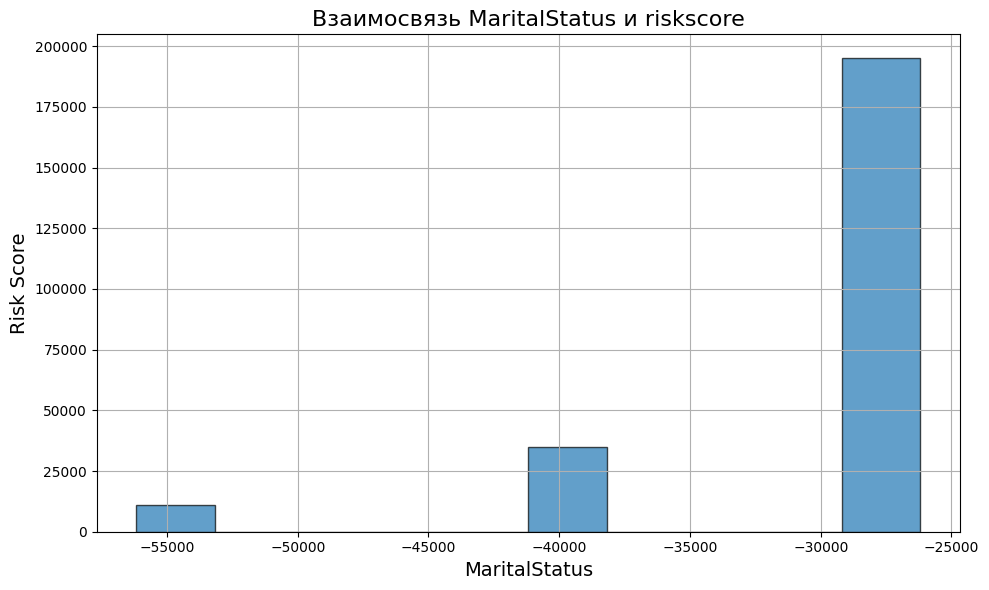

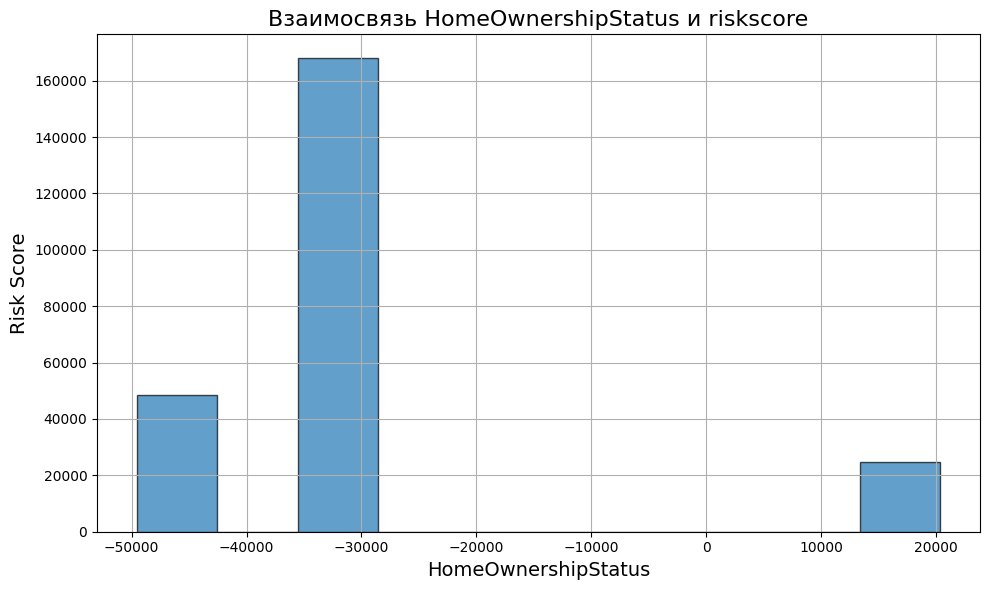

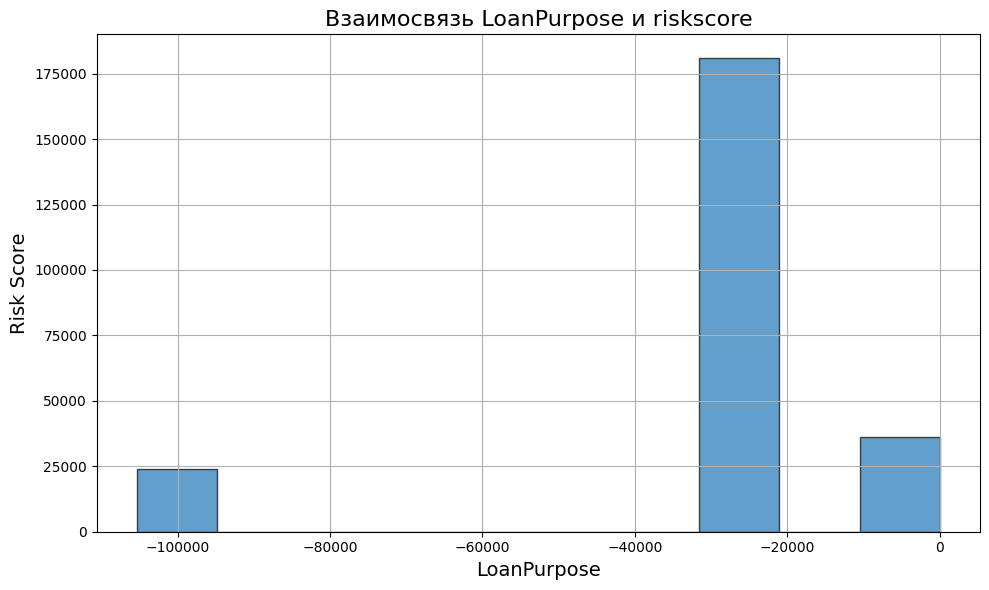

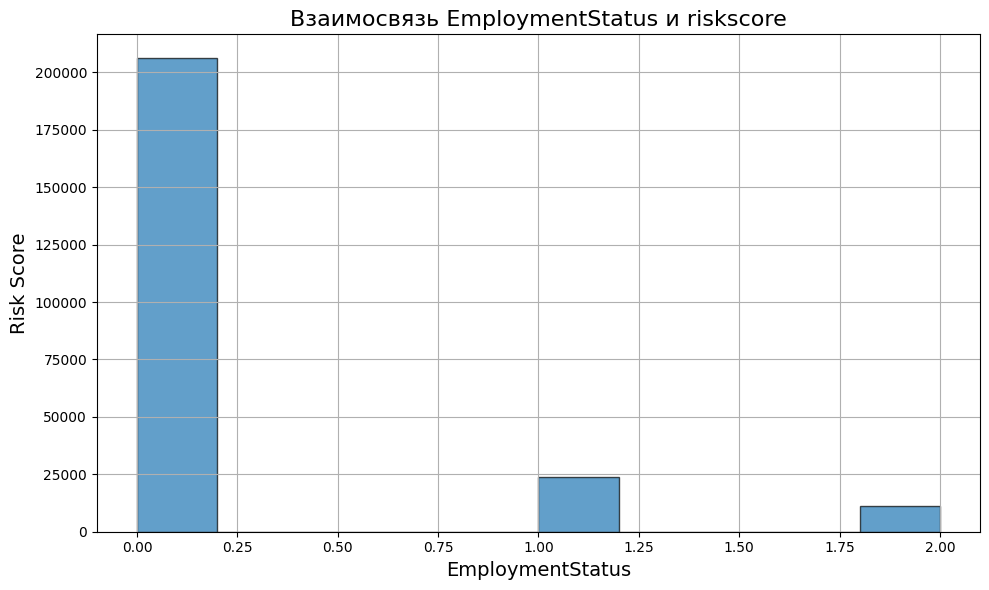

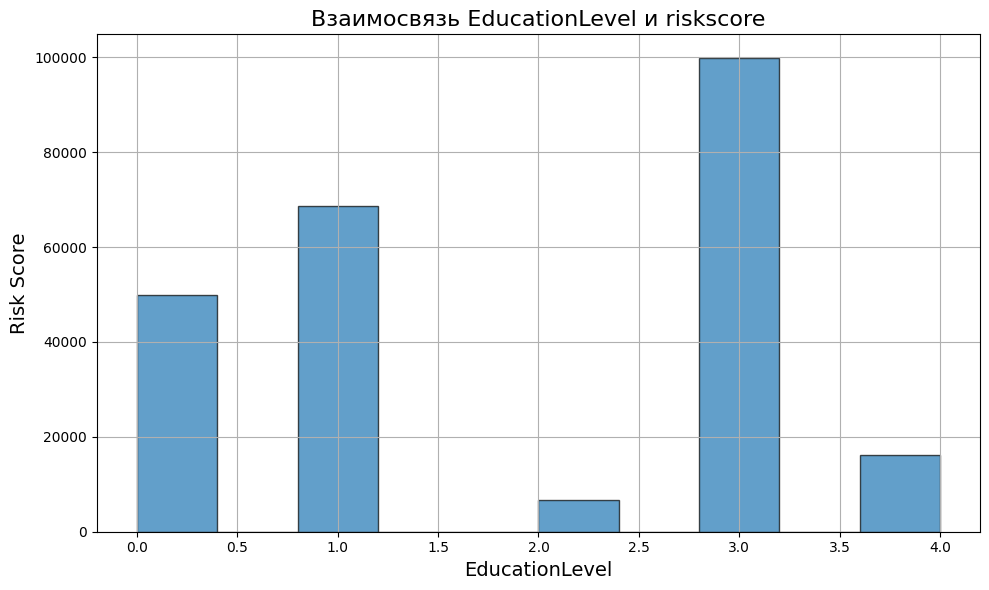

In [47]:
for feature in features.drop([ 'ApplicationDate']):
    plt.figure(figsize=(10, 6))
    plt.hist(test[feature], weights=test['RiskScore'], alpha=0.7, edgecolor='k')
    plt.title(f'Взаимосвязь {feature} и riskscore', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Risk Score', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()